[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aymgal/herculens_workspace/blob/new-param-interface/notebooks/herculens__Complex_galaxy_with_wavelets.ipynb)

# Modeling a complex (unlensed) galaxy with wavelets

__author__: @aymgal

__last updated__: 14/02/23

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # Installing requirements and dependencies
    !pip install --quiet git+https://github.com/austinpeel/herculens.git
    !pip install --quiet blackjax==0.9.6 numpyro==0.10.1 emcee==3.0.2
    !pip install --quiet jaxns dynesty getdist

In [1]:
# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm, LogNorm, Normalize, TwoSlopeNorm
plt.rc('image', interpolation='none')

# Basic imports
import os
from time import time
import numpy as np
from astropy.io import fits
from copy import deepcopy
from pprint import pprint
%matplotlib inline

import jax.numpy as jnp

# Herculens imports
from herculens.Coordinates.pixel_grid import PixelGrid
from herculens.Instrument.psf import PSF
from herculens.Instrument.noise import Noise
from herculens.LightModel.light_model import LightModel
from herculens.MassModel.mass_model import MassModel
from herculens.LensImage.lens_image import LensImage
#from herculens.Parameters.parameters import Parameters
from herculens.Inference.ProbModel.numpyro import NumpyroModel
from herculens.Inference.Optimization.optax import OptaxOptimizer
from herculens.Inference.loss import Loss
#from herculens.Inference.optimization import Optimizer
from herculens.Analysis.plot import Plotter
from herculens.Util import image_util, param_util, plot_util

# Baseline font soze
FS = 18

# Plotting engine
plotter = Plotter(base_fontsize=FS, flux_vmin=1e-3, flux_vmax=1e0, res_vmax=6)

## 1. Simulate an observation of a lensed source

### Data grids (image plane and source plane)
For simplicity at first, assume both share the same pixelization.

In [3]:
npix = 40  # number of pixel on a side
pix_scl = 0.08  # pixel size in arcsec
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2  # position of the (0, 0) with respect to bottom left pixel
transform_pix2angle = pix_scl * np.eye(2)  # transformation matrix pixel <-> angle
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}

# create the PixelGrid class
pixel_grid = PixelGrid(**kwargs_pixel)
xgrid, ygrid = pixel_grid.pixel_coordinates
extent = pixel_grid.extent

print(f"image size : ({npix}, {npix}) pixels")
print(f"pixel size : {pix_scl} arcsec")
print(f"x range    : {xgrid[0, 0], xgrid[0, -1]} arcsec")
print(f"y range    : {ygrid[0, 0], ygrid[-1, 0]} arcsec")

image size : (40, 40) pixels
pixel size : 0.08 arcsec
x range    : (-1.56, 1.56) arcsec
y range    : (-1.56, 1.56) arcsec


### Point spread function (PSF)

For simplicity we assume here a Gaussian PSF.

In [29]:
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': 0.3}
psf = PSF(**kwargs_psf)

### Noise

In [30]:
# exposure time, used for estimating the shot noise
exp_time = 2000
# standard deviation of the background noise
sigma_bkd = 0.005

kwargs_noise = {'background_rms': sigma_bkd, 'exposure_time': exp_time}
noise = Noise(npix, npix, **kwargs_noise)

### Load the galaxy

We construct use a galaxy merger observed with HST as realistic example of a complex source.

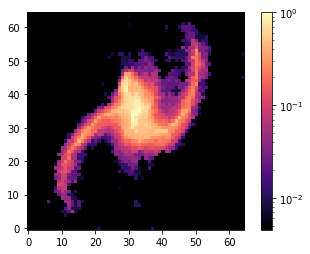

In [31]:
from skimage.transform import rescale
from skimage.morphology import erosion
merger = fits.getdata(os.path.join('data', 'NGC2623.fits'), header=False).astype(float)
merger = merger[100:-20, 20:-100]
merger = rescale(merger, 0.1, anti_aliasing=False)
merger[merger < 0] = 0

# clean small stellar clumps
merger = erosion(merger)

# we increase the contrast
#merger = np.log10(merger) + 1
#merger[merger < 0] = 0
merger[merger < 3e-3] = 0

# we normalize so that it is
merger /= merger.max()

plt.imshow(merger, origin='lower', cmap=plotter.cmap_flux, norm=LogNorm())
plt.colorbar()
plt.show()

In [32]:
kwargs_merger = {
    'pixel_scale_factor': 0.6,  # in arcsec
}
pprint(kwargs_merger)
light_model_input = LightModel(['PIXELATED'], pixel_interpol='bicubic',
                                kwargs_pixelated=kwargs_merger)
amp_src = 1. # 3e-1
kwargs_galaxy_input = [{'pixels': amp_src * merger}]

{'pixel_scale_factor': 0.6}


### Generate the lens image

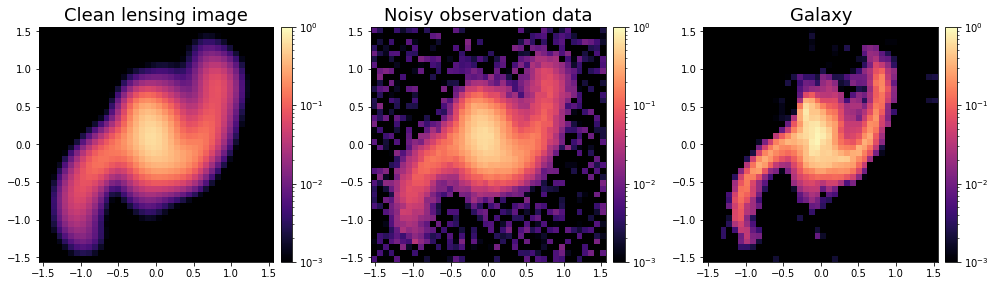

In [33]:
# Generate a lensed image based on source and lens models
kwargs_numerics_simu = {'supersampling_factor': 5}
lens_image_simu = LensImage(pixel_grid, psf, noise_class=noise,
                            lens_light_model_class=light_model_input,
                            kwargs_numerics=kwargs_numerics_simu)

kwargs_all_input = dict(kwargs_lens_light=kwargs_galaxy_input)
image = lens_image_simu.model(**kwargs_all_input)

data = lens_image_simu.simulation(**kwargs_all_input, compute_true_noise_map=True, noise_seed=29)

galaxy_input = lens_image_simu.lens_surface_brightness(kwargs_galaxy_input, unconvolved=True)
#extent_src = lens_image_simu.SourceModel.pixel_grid.extent

# visualize simulated products
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
img1 = ax1.imshow(image, origin='lower', extent=extent, norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plot_util.nice_colorbar(img1)
ax1.set_title("Clean lensing image", fontsize=FS)
img2 = ax2.imshow(data, origin='lower', extent=extent, norm=plotter.norm_flux, cmap=plotter.cmap_flux)
ax2.set_title("Noisy observation data", fontsize=FS)
plot_util.nice_colorbar(img2)
img3 = ax3.imshow(galaxy_input, origin='lower', extent=extent, norm=plotter.norm_flux, cmap=plotter.cmap_flux)
ax3.set_title("Galaxy", fontsize=FS)
plot_util.nice_colorbar(img3)
fig.tight_layout()
plt.show()

## 2. Pixelated reconstruction

### Create a model for fitting

In [34]:
# Setup the source model: pixelated on a regular grid
kwargs_pixelated = {
    'pixel_scale_factor': 1.,  # = data pixel size / source pixel size
}
light_model = LightModel(['PIXELATED'], kwargs_pixelated=kwargs_pixelated)

kwargs_numerics_fit = {'supersampling_factor': 5}
lens_image = LensImage(deepcopy(pixel_grid), psf, noise_class=noise,
                       lens_light_model_class=light_model,
                       kwargs_numerics=kwargs_numerics_fit)

galaxy_size = lens_image.LensLightModel.pixel_grid.num_pixel
galaxy_shape = lens_image.LensLightModel.pixel_grid.num_pixel_axes
print(galaxy_shape, galaxy_size)

(40, 40) 1600


In [35]:
# inform the plotter of the data
plotter.set_data(data)

# inform the plotter about the true source (on the pixelated grid)
x_grid_src, y_grid_src = lens_image.LensLightModel.pixel_grid.pixel_coordinates
galaxy_input_fitgrid = lens_image_simu.LensLightModel.surface_brightness(x_grid_src, y_grid_src, kwargs_galaxy_input)
galaxy_input_fitgrid *= lens_image.Grid.pixel_area
plotter.set_ref_lens_light(galaxy_input_fitgrid)

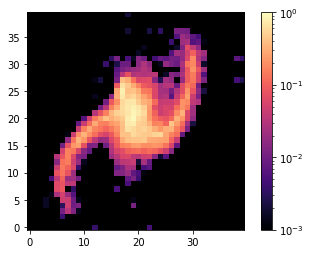

In [36]:
plt.imshow(galaxy_input_fitgrid, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plt.colorbar()
plt.show()

#### Noise propagation

In [37]:
from utax.wavelet import WaveletTransform

nxsrc, nysrc = galaxy_shape
nscales = int(np.log2(nxsrc))
starlet = WaveletTransform(nscales, wavelet_type='starlet', second_gen=True)
true_source_coeffs = starlet.decompose(galaxy_input_fitgrid)
print(true_source_coeffs.shape)
print(true_source_coeffs[-1].min(), true_source_coeffs[-1].max())

(6, 40, 40)
0.012722902 0.02833469


In [38]:
import jax
from herculens.LensImage.lensing_operator import LensingOperator


def data_noise_to_wavelet_source(num_samples=10000):

    image_jax = data[jnp.newaxis, :, :, jnp.newaxis]  # NHWC
    kernel = psf.kernel_point_source
    nxk, nyk = kernel.shape
    kernel_jax = kernel[:, :, jnp.newaxis, jnp.newaxis]  # HWIO

    dimension_numbers = ('NHWC', 'HWIO', 'NHWC')
    dn = jax.lax.conv_dimension_numbers(image_jax.shape, 
                                    kernel_jax.shape, 
                                    dimension_numbers)
    kernel_rot = jnp.rot90(jnp.rot90(kernel_jax, axes=(0,1)), axes=(0,1))
    
    diag_cov_d = lens_image_simu.Noise.C_D_model(image)
    std_d = np.sqrt(diag_cov_d)
    
    def B_T(n):
        res = jax.lax.conv_general_dilated(n[jnp.newaxis, :, :, jnp.newaxis], 
                                       kernel_rot, 
                                       (1,1), #(k//2,k//2),  # window strides
                                       ((nxk//2, nyk//2), (nxk//2, nyk//2)), # padding mode
                                       (1,1), #(k//2,k//2),  # lhs/image dilation
                                       (1,1),  # rhs/kernel dilation
                                       dn)     # dimension_numbers = lhs, rhs, out dimension permutation
        return jnp.squeeze(res)
    
    def Phi_T(n):
        return starlet.decompose(n)
    
    @jax.vmap
    def propagate_noise(n):
        # multiply by the inverse of the data (diagonal) covariance matrix
        n /= diag_cov_d
        # transposed convolution
        n = B_T(n)
        # transform to wavelet space
        n = Phi_T(n)
        #debug = noise_i.copy()
        return n #, debug
    
    noise_samples = std_d[None, :, :] * jax.random.normal(jax.random.PRNGKey(0), shape=(num_samples, npix, npix))
    noise_samples_prop = propagate_noise(noise_samples)
    std_per_scale = jnp.std(noise_samples_prop, axis=0)
    return std_per_scale #, debug

In [39]:
regul_weights = data_noise_to_wavelet_source(num_samples=5000)

(6, 40, 40)
3.6541786 18.972734
5


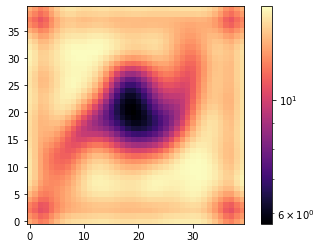

In [43]:
print(regul_weights.shape)
print(regul_weights.min(), regul_weights.max())
print(nscales)

#print(debug.shape)

plt.imshow(regul_weights[2], origin='lower', norm=LogNorm(), cmap=plotter.cmap_flux)
#plt.imshow(debug[3], origin='lower', norm=Normalize(), cmap=plotter.cmap_flux)
plt.colorbar()
plt.show()

In [51]:
import numpyro
import numpyro.distributions as dist
from numpyro.distributions import constraints
import numpyro.util as numpyro_util
from numpyro import handlers

class ProbModel(NumpyroModel):
    
    def model(self):
        
        # Let's try by sampling directly in wavelet space
        lambdas = jnp.array([5.] + [3.]*(nscales-1))[:, None, None]  # regularization strength
        mu_scales = jnp.zeros((nscales, nxsrc, nysrc))
        b_scales = 1. / (lambdas * regul_weights[:-1])
        dist_scales = dist.Laplace(mu_scales, b_scales)
        galaxy_scales = numpyro.sample('galaxy_scales', dist.Independent(dist_scales, 3))
        
        #dist_coarse = dist.Uniform(jnp.zeros((nxsrc, nysrc)), jnp.ones((nxsrc, nysrc)))
        #source_coarse = numpyro.sample('source_coarse', dist.Independent(dist_coarse, 2))
        galaxy_coarse = numpyro.param('galaxy_coarse', init_value=1e-2*jnp.ones(galaxy_shape), 
                                      constraint=constraints.greater_than(0.), event_dim=galaxy_shape)
        
        pixels = self.coeffs2galaxy(galaxy_scales, galaxy_coarse)

        prior_light = [{'pixels': pixels}]
        model_params = dict(kwargs_lens_light=prior_light)
        
        # generates the model image
        model_image = lens_image.model(**model_params)
        
        # estimate the error per pixel
        model_error = jnp.sqrt(noise.C_D_model(model_image))
        
        # finally defines the observed node, conditioned on the data assuming a Gaussian distribution
        numpyro.sample('obs', dist.Independent(dist.Normal(model_image, model_error), 2), obs=data)
    
    def coeffs2galaxy(self, scales, coarse):
        return starlet.reconstruct(jnp.concatenate([scales, coarse[jnp.newaxis, :, :]], axis=0))
   
    def params2kwargs(self, params):
        # functions that takes the flattenned dictionary of numpyro parameters
        # and reshape it back to the argument of lens_image.model()
        pixels = self.coeffs2galaxy(params['galaxy_scales'], params['galaxy_coarse'])
        kw = {
            'kwargs_lens_light': [{'pixels': pixels}],
        }
        return kw
    
    #def kwargs2params(self, kwargs):
    #    from jax.tree_util import tree_flatten
    #    return tree_flatten(kwargs)

prob_model = ProbModel()
n_param = prob_model.num_parameters
print("Number of parameters:", n_param)

Number of parameters: 9600


### Loss function

In [52]:
loss = Loss(lens_image, prob_model)

Loss at initial values: 25264.742


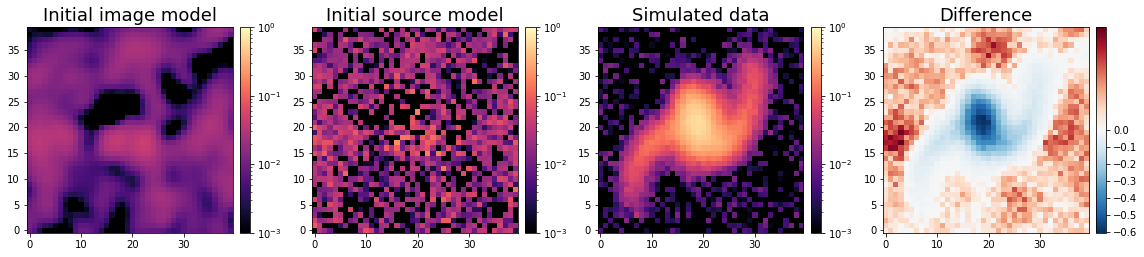

In [53]:
init_params = prob_model.get_sample(seed=0)
kwargs_init = prob_model.params2kwargs(init_params)
#pprint(kwargs_init)

print("Loss at initial values:", loss(init_params))

# visualize initial guess
initial_model = lens_image.model(**kwargs_init)
initial_source = lens_image.LensLightModel.surface_brightness(x_grid_src, y_grid_src, kwargs_init['kwargs_lens_light']) * lens_image.Grid.pixel_area


fig, axes = plt.subplots(1, 4, figsize=(16, 4))
ax = axes[0]
ax.set_title("Initial image model", fontsize=FS)
im = ax.imshow(initial_model, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plot_util.nice_colorbar(im)
ax = axes[1]
ax.set_title("Initial source model", fontsize=FS)
im = ax.imshow(initial_source, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plot_util.nice_colorbar(im)
ax = axes[2]
ax.set_title("Simulated data", fontsize=FS)
im = ax.imshow(data, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plot_util.nice_colorbar(im)
ax = axes[3]
ax.set_title("Difference", fontsize=FS)
im = ax.imshow(initial_model - data, origin='lower', norm=TwoSlopeNorm(0), cmap=plotter.cmap_res)
plot_util.nice_colorbar(im)
fig.tight_layout()
plt.show()

### Minimise the loss function using `optax`

We use the adaptive gradient descent algorithm AdaBelief to optimize the values of all source pixels.

In [54]:
optimizer = OptaxOptimizer(loss, loss_norm_optim=1.)

# optimizer settings
max_iterations = 2000
init_learning_rate = 5e-4

best_fit, logL, extra_fields, runtime \
    = optimizer.run(init_params, max_iterations=max_iterations, 
                    init_learning_rate=init_learning_rate)
print(f"Runtime: {runtime}")
print("Loss at best-fit:", loss(best_fit))

optax.adabelief: 100%|██████████| 2000/2000 [00:20<00:00, 96.67it/s] 


Runtime: 20.689902782440186
Loss at best-fit: -26333.238


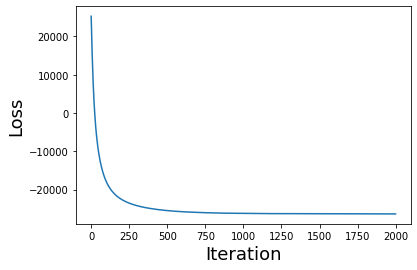

In [55]:
kwargs_bestfit = prob_model.params2kwargs(best_fit)

fig, ax = plt.subplots(1, 1)
ax.plot(range(len(extra_fields['loss_history'])), extra_fields['loss_history'])
ax.set_ylabel("Loss", fontsize=18)
ax.set_xlabel("Iteration", fontsize=18)
plt.show()

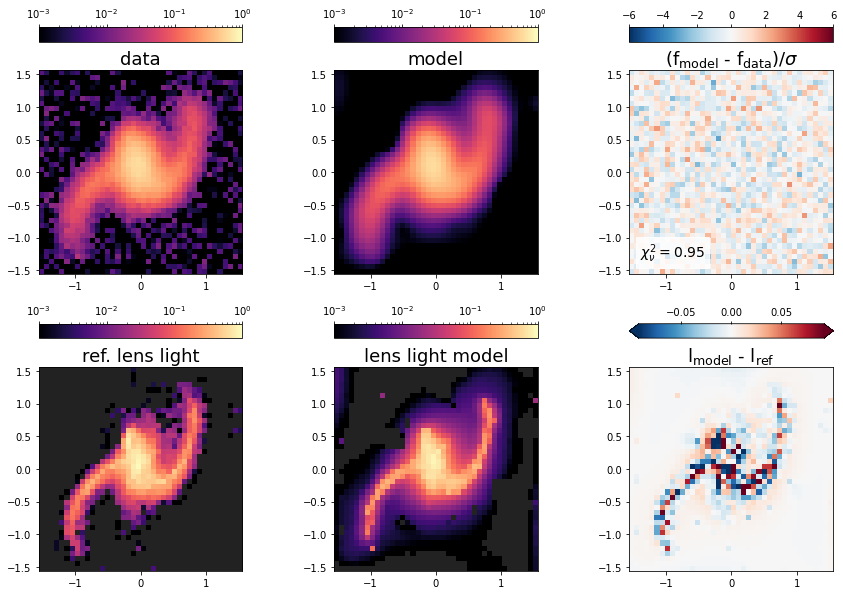

In [56]:
fig = plotter.model_summary(lens_image, kwargs_bestfit, show_source=False, show_lens_light=True)
plt.show()

In [57]:
print(best_fit['galaxy_scales'].shape, best_fit['galaxy_coarse'].shape)
kwargs_bestfit['kwargs_lens_light'][0]['pixels'][20:25, 20:25]

(5, 40, 40) (40, 40)


DeviceArray([[0.7489713 , 0.5193789 , 0.2203897 , 0.13930972, 0.09843311],
             [0.758556  , 0.5042194 , 0.19286367, 0.11400115, 0.07475688],
             [0.6639584 , 0.37453964, 0.183539  , 0.0966615 , 0.06074677],
             [0.76074636, 0.3167113 , 0.15017906, 0.08056485, 0.04975577],
             [0.3870938 , 0.37128127, 0.1596004 , 0.06419426, 0.03947467]],            dtype=float32)

### Variational inference

In [58]:
import numpyro
import numpyro.distributions as dist
from numpyro import optim
from numpyro.infer import Predictive, SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoBNAFNormal, AutoDelta

guide = AutoBNAFNormal(prob_model.model, num_flows=1, hidden_factors=[8, 8])

In [ ]:
num_iters = 1000

learning_rate = 3e-3
optimizer_vi = optim.Adam(learning_rate)

#import optax
#learning_rate = 3e-3
#optimizer_vi = optim.optax_to_numpyro(optax.adabelief(learning_rate))

svi = SVI(prob_model.model, guide, optimizer_vi, Trace_ELBO())
print("Start training guide...")
svi_result = svi.run(jax.random.PRNGKey(1), num_iters)
print("Finish training guide. Extract samples...")

Start training guide...


In [ ]:
num_samples = 5000
posterior_samples = guide.sample_posterior(
    jax.random.PRNGKey(2), svi_result.params, 
    sample_shape=(num_samples,)
)

In [ ]:
prior_samples = prob_model.sample_prior(num_samples, seed=18)

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(18, 4))
ax = axes[0]
ax.set_title("groundtruth")

ax = axes[1]
ax.set_title("MAP solution")

ax = axes[2]
ax.set_title("posterior median")

ax = axes[3]
ax.set_title("posterior mean")

ax = axes[4]
ax.set_title("posterior median")